# Selective Search function

In [15]:
import skimage.data
from skimage import io
import skimage.transform as T
import skimage.util as util
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

IMG_HEIGHT = 224
IMG_WIDTH = 224

def get_regions_propsal(imgpath):
    #reading image from file
    img = io.imread(imgpath)
    img = T.resize(img,(IMG_HEIGHT,IMG_WIDTH,3),mode='reflect')
    
    
    #get region proposal using selective search
    img_lbl, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=100)
    
    #show the original image
    plt.imshow(img)
    plt.show()
    
    print("There is %d regions proposed"%len(regions))
    
    #crop the original image according to the regions proposed and store it to a new array
    regions_proposal=list()
    for r in regions:
        rect = r['rect']
        y1 = rect[0]
        y2 = rect[0] + rect[2]
        x1 = rect[1]
        x2 = rect[1] + rect[3]
        cropped_im = img[x1:x2,y1:y2]
        #this is problematic
        #cropped_im = T.resize(cropped_im,(IMG_HEIGHT,IMG_WIDTH,3),mode='constant')
        regions_proposal += [(cropped_im,rect)]
    
    return regions_proposal,regions



# Warping Selective Search Result

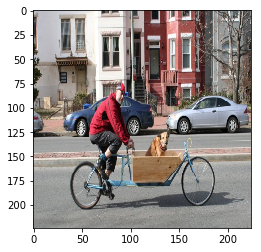

There is 120 regions proposed
All image regions have been created


In [22]:
import warnings

reg_prop,raw_regions = get_regions_propsal('images/test.jpg')
regions = list()

for i,rp in enumerate(reg_prop):
    #continue;
    image = T.resize(rp[0],(IMG_HEIGHT,IMG_WIDTH,3),mode='constant')
    path = "images/%d__%s.jpg"%(i,rp[1])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        io.imsave(path,image)
    regions += [{"num":i,"filepath":path,"rect":rp[1]}]
    
print("All image regions have been created")

In [23]:
def ShowRegionProposal(reg):  
    img = io.imread('images/test.jpg')
    img = T.resize(img,(IMG_HEIGHT,IMG_WIDTH,3),mode='reflect')
    candidates = set()
    for r in reg:
    # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

        # draw rectangles on the original image
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        ax.imshow(img)
        for x, y, w, h in candidates:
            #print(x, y, w, h)
            rect = mpatches.Rectangle(
                (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            ax.add_patch(rect)
    plt.show()
    

def displayRegion(r,label,prob):
            #reading image from file
        img = io.imread('images/test.jpg')
        img = T.resize(img,(IMG_HEIGHT,IMG_WIDTH,3),mode='reflect')
    
        # distorted rects
        x, y, w, h = r
        # draw rectangles on the original image
        
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        ax.imshow(img)
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        plt.title("%s: p %.2f"%(label,prob));
        plt.show()
 

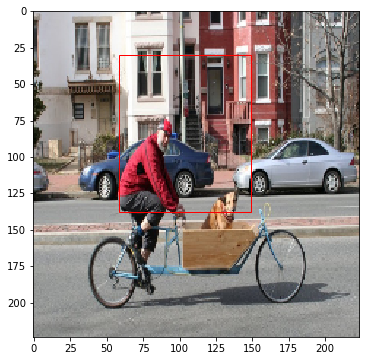

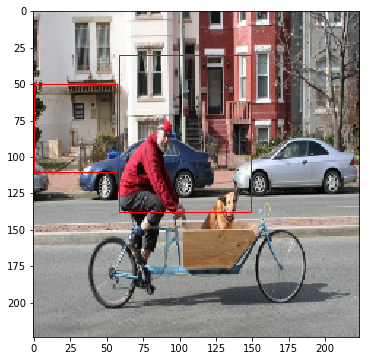

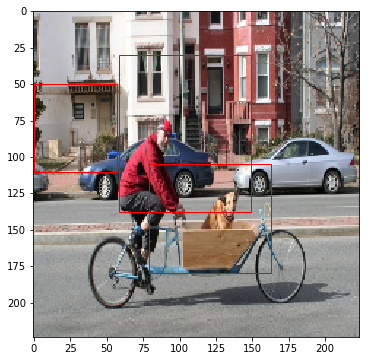

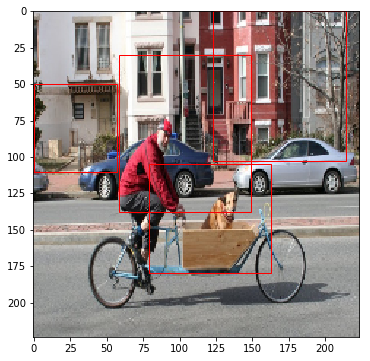

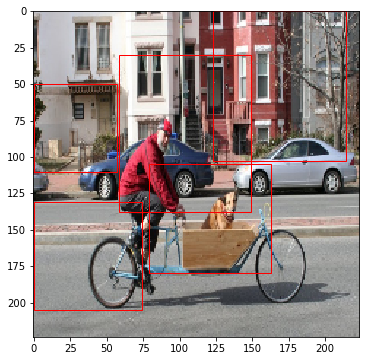

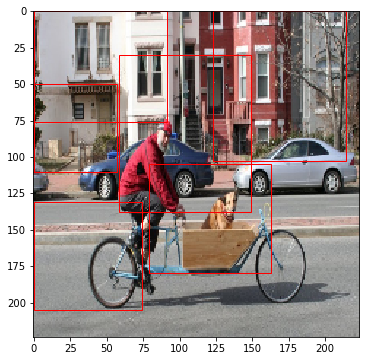

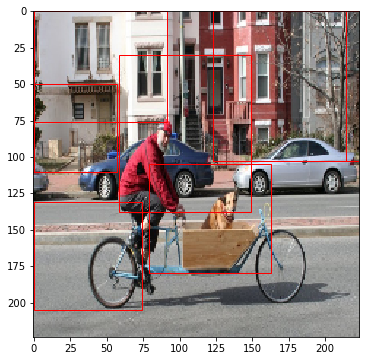

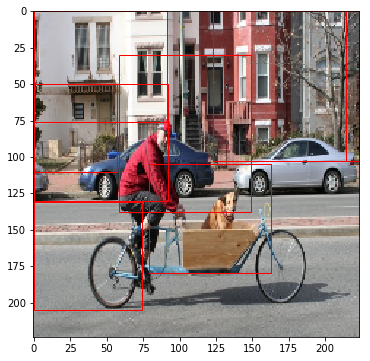

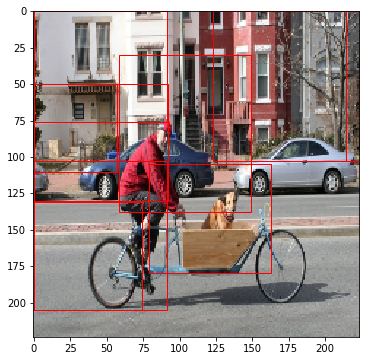

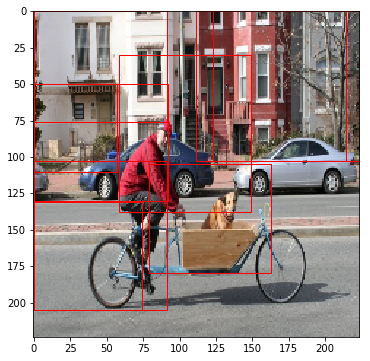

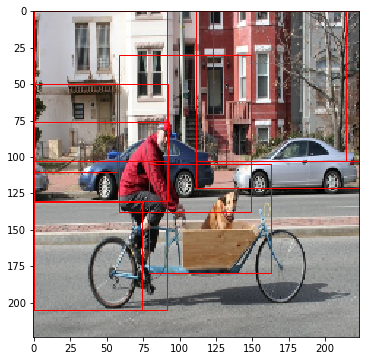

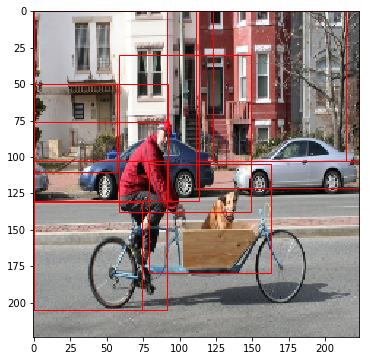

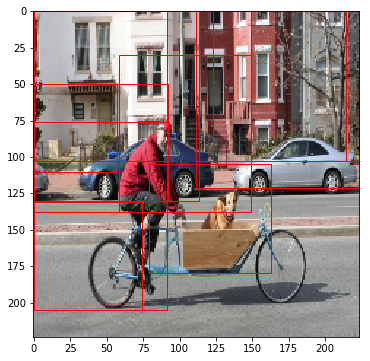

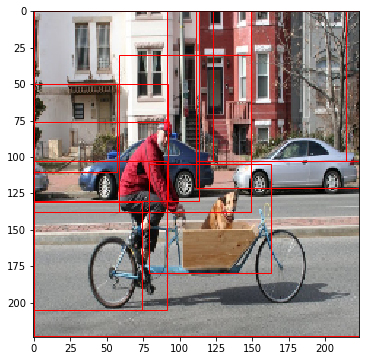

In [25]:
ShowRegionProposal(raw_regions)

# Load ResNet50 using Keras

In [26]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np

from keras.applications.resnet50 import ResNet50
#Load ResNet50 architecture & its weights
modelRestNet50 = ResNet50(include_top=True, weights='imagenet')



# Object detection on Raw ResNet50

120
46 - mountain_bike found in:(37, 137, 37, 68)


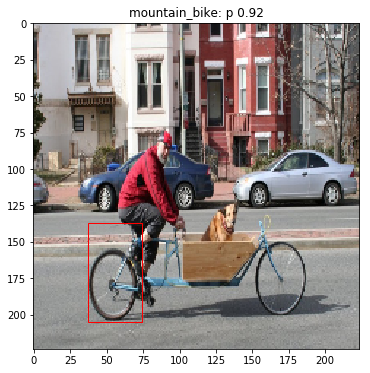

22 - entertainment_center found in:(115, 38, 16, 36)


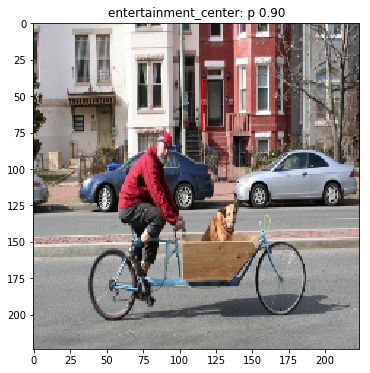

109 - bicycle-built-for-two found in:(0, 103, 91, 102)


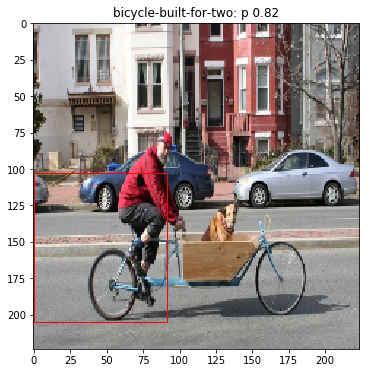

64 - jinrikisha found in:(42, 155, 139, 49)


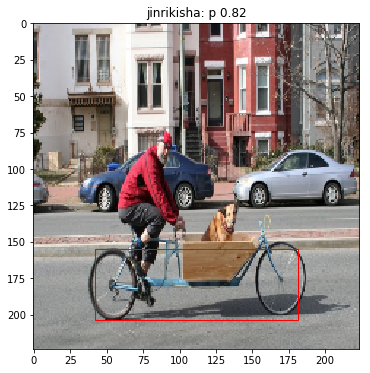

39 - dumbbell found in:(138, 109, 85, 22)


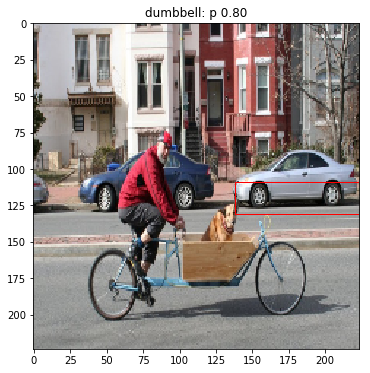

48 - paper_towel found in:(159, 141, 64, 10)


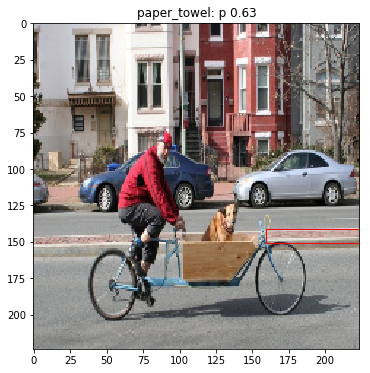

55 - fire_screen found in:(155, 156, 29, 33)


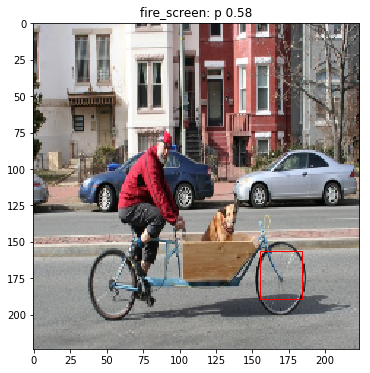

62 - crate found in:(98, 128, 58, 47)


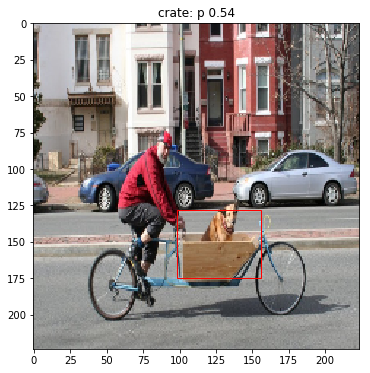

95 - palace found in:(0, 0, 91, 76)


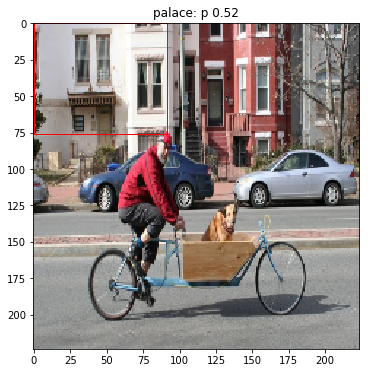

32 - steel_arch_bridge found in:(138, 82, 64, 21)


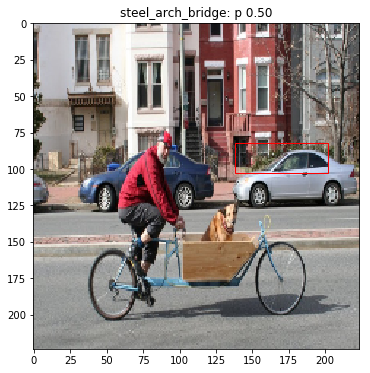

49 - theater_curtain found in:(0, 145, 67, 8)


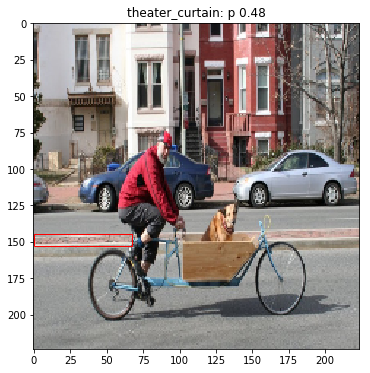

86 - cash_machine found in:(111, 0, 26, 80)


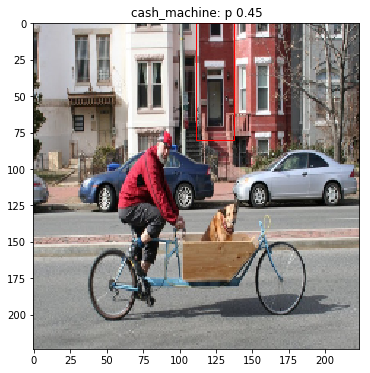

16 - mobile_home found in:(69, 22, 20, 42)


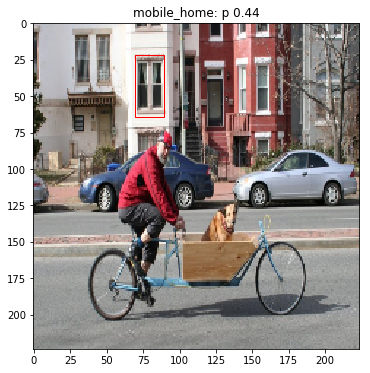

35 - beach_wagon found in:(140, 90, 81, 31)


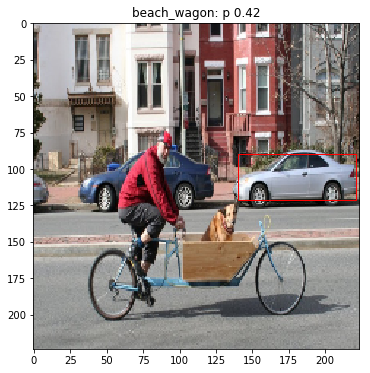

23 - moving_van found in:(184, 45, 30, 51)


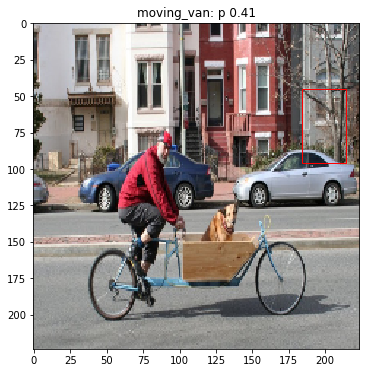

In [28]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image

IMG_HEIGHT = 224
IMG_WIDTH = 224
objects = list()
print(len(regions))
for r in regions:
    #load the image corresponding to the image
    img_path = r["filepath"]
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    
    #preprocess for a ResNet50 input
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    #predict and store TOP #K prediction
    predicts=modelRestNet50.predict(x)
    predictions = decode_predictions(predicts, top=1)[0]
    for p in predictions:
        objects +=[(img_path,r['rect'],p[1],float(p[2]),r['num'])] #store label and its probability
    
all_objects = sorted(objects, key=lambda x: x[3], reverse=True)

detected_objects = []
labels = []

for o in all_objects:
    if o[2] not in labels:
        labels += [o[2]]
        detected_objects += [o]

for o in detected_objects[0:15]: 
    print("%d - %s found in:%s"%(o[4],o[2],o[1]))
    displayRegion(o[1],o[2],o[3])
    

#print(set([o for (_,o,_) in detected_objects]))

# Region Proposal Finetuning On PASCAL VOC 2007

In [7]:
modelRestNet50.layers.pop()
# Modify top layers
x = modelRestNet50.layers[-1].output
x = Dense(20, activation='sigmoid', name='predictions')(x)
model = Model(input=modelRestNet50.input,output=x)

#on souhaite apprendre les paramètres de l’ensemble du réseau 
for L in model.layers:
    L.trainable = True

lr = 0.1
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=lr), metrics=['binary_accuracy'])

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  """


# Finetuning RestNet50 on PASCAL VOC 2007

In [8]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np


from keras.applications.resnet50 import ResNet50
# Load ResNet50 architecture & its weights
model = ResNet50(include_top=True, weights='imagenet')
model.layers.pop()
# Modify top layers
x = model.layers[-1].output
x = Dense(20, activation='sigmoid', name='predictions')(x)
model = Model(input=model.input,output=x)

#on souhaite apprendre les paramètres de l’ensemble du réseau 
for L in model.layers:
    L.trainable = True

lr = 0.1
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=lr), metrics=['binary_accuracy'])

from data_gen import PascalVOCDataGenerator
data_dir = ('C:\\data\\VOCdevkit\\VOC2007\\')

#train
data_generator_train = PascalVOCDataGenerator('trainval', data_dir)


batch_size=32
nb_epochs=10
steps_per_epoch_train = int(len(data_generator_train.id_to_label) / batch_size) + 1
model.fit_generator(data_generator_train.flow(batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=nb_epochs,
                    verbose=1)


KeyboardInterrupt: 

# Labelisation of Region Proposals

In [1]:
import os;
import skimage.data
from skimage import io
import skimage.transform as T
import skimage.util as util
import selectivesearch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%load_ext autoreload
%autoreload 1
%aimport od_data_gen

from od_data_gen import DataGen

DATAPATH = 'C:\\data\\VOCdevkit\\VOC2007\\'


data_gen = DataGen('trainval', DATAPATH)

#data_gen._generate_batch(100)
#X,Y = data_gen.get_xy_from_image(1)
#print(X.shape,Y.shape)



Using TensorFlow backend.


1337937


In [2]:
dic = data_gen.DataDict
print(dic)



{5: 233, 7: 211}


# Extract Features from ResNet50

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np


from keras.applications.resnet50 import ResNet50
# Load ResNet50 architecture & its weights
model = ResNet50(include_top=True, weights='imagenet')
model.layers.pop()
model = Model(input=model.input,output=model.layers[-1].output)
model.compile(loss='binary_crossentropy', optimizer=SGD(0.5, momentum=0.9), metrics=['binary_accuracy'])


data_set = data_gen.DataSet
dic = data_gen.DataDict
total_images = data_gen.TotalDataSet


# Initilisation des matrices contenant les Deep Features et les labels
X_train = np.zeros((total_images,2048))
Y_train = np.zeros((total_images,21))

k=0
for i in data_set:
    nb_region = dic[i]
    
    # Pour chaque image, on extrait les images des regions d'entrée X et les labels y
    X,Y = data_gen.get_xy_from_image(i)
    
    # On récupère les Deep Feature par appel à predict
    y_pred = model.predict(X)
        
    X_train[k:k+nb_region,:] = y_pred
    Y_train[k:k+nb_region,:] = Y
    
    k=nb_region
#X,Y = data_gen.get_xy_from_image(1)

print(X_train.shape)
print(Y_train.shape)


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  # This is added back by InteractiveShellApp.init_path()


(444, 2048)
(444, 21)


In [26]:
Y_pred = model.predict(X)
print(Y_pred.shape)

(181, 2048)


# Load ResNet50 using Keras

In [4]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
import numpy as np


from keras.applications.resnet50 import ResNet50
# Load ResNet50 architecture & its weights
model = ResNet50(include_top=True, weights='imagenet')
model.layers.pop()
# Modify top layers
x = model.layers[-1].output
x = Dense(21, activation='softmax', name='predictions')(x)
model = Model(input=model.input,output=x)


for L in model.layers:
    L.trainable = False
    
model.layers[-1].trainable = True

lr = 0.001
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=lr), metrics=['binary_accuracy'])

from od_data_gen import DataGen
data_dir = ('C:\\data\\VOCdevkit\\VOC2007\\')

#train
data_generator_train = DataGen('trainval', data_dir)


batch_size=100
nb_epochs=10
steps_per_epoch_train = int(data_generator_train.total_nb_images / batch_size) + 1

#data_generator_train._generate_batch()


model.fit_generator(data_generator_train.flow2(batch_size=batch_size),
                    steps_per_epoch=steps_per_epoch_train,
                    epochs=nb_epochs,
                    verbose=1)


C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


1337937
Epoch 1/10
    9/13380 [..............................] - ETA: 158:36:28 - loss: 0.2245 - binary_accuracy: 0.9517

KeyboardInterrupt: 

### Read label files and images in directory

In [48]:
from os import listdir
from os.path import isfile, join
mypath = "C:\\Users\\pc\\Documents\\Jupyter\\RCNN_SOA\\images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

import numpy as np
files = np.asarray(onlyfiles)
fileLines =[]

files = np.asarray([[int(s.split('_')[0]),int(s.split('_')[1].split('.')[0])] for s in onlyfiles ])
fileLines = np.loadtxt('annotations/labels.txt')




### Get difference between labels and image files

In [49]:
diff = []
for i in range(1,6404):
    regions =  np.where(fileLines[:,0]==i)[0]
    nbr+=[len(regions)]
    nb_regions = len(regions)
    
    imageFiles = np.where(files[:,0]==i)[0]
    nb_files = len(imageFiles)
    
    if(nb_regions != nb_files):
        diff+=["%06d"%i]
    
print(diff)   


[]
